# Fall Detection — CHEST CLIP Mode
**MPU6050 placement: Chest clip**

---
## Dataset: SisFall
| Item | Detail |
|------|--------|
| **Path** | `data/SisFall/` |
| **Subjects** | 23 adults (SA01-SA23) + 15 elderly (SE01-SE15) |
| **Falls** | F01-F15, 5 trials each (adult subjects) |
| **ADL** | D01-D19 |
| **Sampling** | 200 Hz → 50 Hz (every 4th sample) |
| **Format** | 9 cols comma-separated, trailing `;` on last col |
| **Unit conv** | ADXL345 cols 0-2: ×(32/8192) → g · ITG3200 cols 3-5: ×(4000/65536) → °/s |

In [1]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from autogluon.tabular import TabularPredictor
warnings.filterwarnings('ignore')

PLACEMENT    = 'CHEST'
DATA_DIR     = 'data/SisFall'
SAMPLE_RATE  = 50
DOWNSAMPLE   = 4
WINDOW_SIZE  = 100
STEP_SIZE    = 50
RANDOM_STATE = 42
ADXL_SCALE   = 32.0 / 8192.0
ITG_SCALE    = 4000.0 / 65536.0
os.makedirs('models', exist_ok=True)
print(f'Config: {PLACEMENT}, {SAMPLE_RATE} Hz, {WINDOW_SIZE/SAMPLE_RATE}s window')

Config: CHEST, 50 Hz, 2.0s window


/Users/frank/Vscode/Hardware-Project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load SisFall

In [2]:
def load_sisfall(data_dir):
    records = []
    for path in glob.glob(os.path.join(data_dir, '**', '*.txt'), recursive=True):
        fname = os.path.basename(path)
        if fname.lower().startswith('readme'):
            continue
        label = 1 if fname.upper().startswith('F') else 0
        try:
            raw = pd.read_csv(path, header=None, sep=',')
            if raw.shape[1] < 6:
                continue
            raw.iloc[:, -1] = (raw.iloc[:, -1].astype(str)
                               .str.replace(';', '', regex=False).str.strip())
            raw = raw.apply(pd.to_numeric, errors='coerce').dropna()
            raw = raw.iloc[::DOWNSAMPLE].reset_index(drop=True)
            df = pd.DataFrame({
                'ax': raw.iloc[:, 0] * ADXL_SCALE,
                'ay': raw.iloc[:, 1] * ADXL_SCALE,
                'az': raw.iloc[:, 2] * ADXL_SCALE,
                'gx': raw.iloc[:, 3] * ITG_SCALE,
                'gy': raw.iloc[:, 4] * ITG_SCALE,
                'gz': raw.iloc[:, 5] * ITG_SCALE,
                'label': label, 'file': fname,
            })
            records.append(df)
        except Exception:
            pass
    if not records:
        raise FileNotFoundError(f'No SisFall .txt files in {data_dir}')
    return pd.concat(records, ignore_index=True)

print('Loading SisFall...')
raw = load_sisfall(DATA_DIR)
print(f'Loaded {len(raw):,} samples from {raw["file"].nunique()} files')
print(f'Falls: {(raw.label==1).sum():,}  |  ADL: {(raw.label==0).sum():,}')
print(raw[['ax','ay','az']].describe().round(3))

Loading SisFall...
Loaded 3,964,862 samples from 4500 files
Falls: 1,348,463  |  ADL: 2,616,399
                ax           ay           az
count  3964862.000  3964862.000  3964862.000
mean        -0.005       -0.698       -0.108
std          0.410        0.586        0.488
min        -16.000      -14.516      -15.984
25%         -0.086       -0.988       -0.359
50%          0.012       -0.898       -0.121
75%          0.102       -0.211        0.129
max         15.992       15.969       15.914


## 2. Signal Visualization

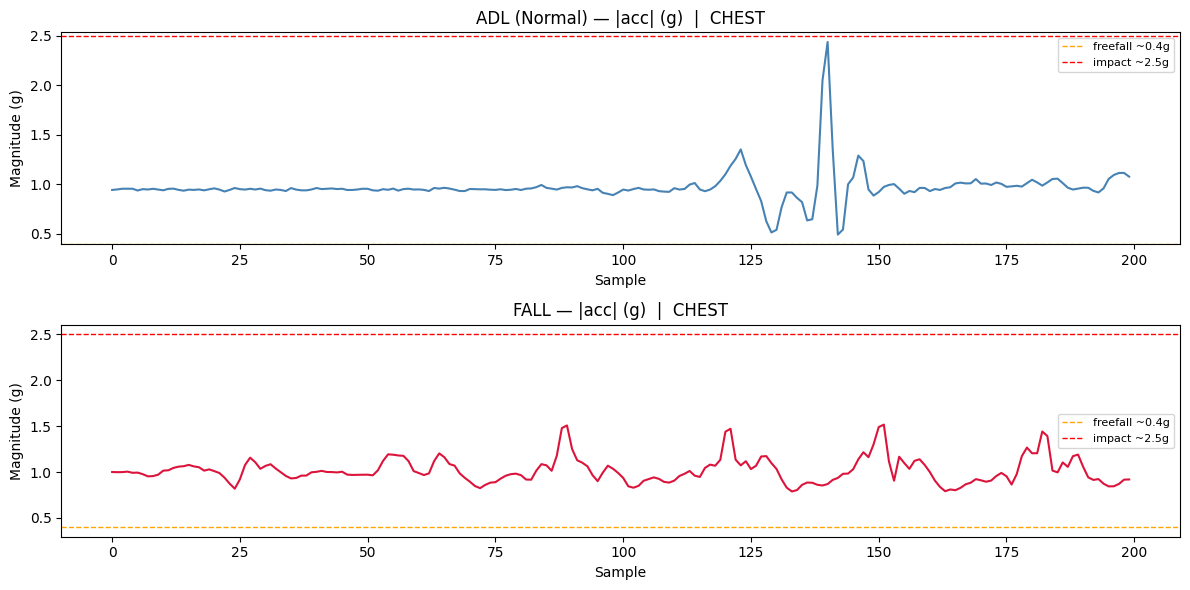

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for ax_p, lbl, color, title in zip(
        axes, [0, 1], ['steelblue', 'crimson'], ['ADL (Normal)', 'FALL']):
    sample = raw[raw['label'] == lbl].head(200)
    mag = np.sqrt(sample['ax']**2 + sample['ay']**2 + sample['az']**2)
    ax_p.plot(mag.values, color=color)
    ax_p.set_title(f'{title} — |acc| (g)  |  {PLACEMENT}')
    ax_p.set_ylabel('Magnitude (g)'); ax_p.set_xlabel('Sample')
    ax_p.axhline(0.4, color='orange', ls='--', lw=1, label='freefall ~0.4g')
    ax_p.axhline(2.5, color='red',    ls='--', lw=1, label='impact ~2.5g')
    ax_p.legend(fontsize=8)
plt.tight_layout()
plt.savefig(f'models/{PLACEMENT}_signal.png', dpi=150)
plt.show()

## 3. Feature Extraction — 23 Features

In [4]:
def extract_features(window, fs=SAMPLE_RATE):
    ax, ay, az = window[:, 0], window[:, 1], window[:, 2]
    mag   = np.sqrt(ax**2 + ay**2 + az**2)
    mag_c = mag - np.mean(mag)
    freqs = fftfreq(len(mag), 1/fs)
    fmag  = np.abs(fft(mag))[:len(mag)//2]
    pf    = freqs[:len(mag)//2]
    jerk  = np.diff(mag) * fs
    f  = [float(np.mean(ax)), float(np.mean(ay)), float(np.mean(az))]
    f += [float(np.std(ax)),  float(np.std(ay)),  float(np.std(az))]
    f += [float(np.min(mag)), float(np.max(mag)), float(np.ptp(mag))]
    f += [float(np.sqrt(np.mean(ax**2))), float(np.sqrt(np.mean(ay**2))), float(np.sqrt(np.mean(az**2)))]
    f += [float(stats.skew(mag)), float(stats.kurtosis(mag))]
    f.append(float(np.sum(np.diff(np.sign(mag_c)) != 0)))
    f.append(float(np.sum(np.abs(ax)+np.abs(ay)+np.abs(az)) / len(ax)))
    f.append(float(pf[np.argmax(fmag)]) if len(fmag) > 0 else 0.0)
    f.append(float(np.sum(fmag**2)))
    f.append(float(np.corrcoef(ax, ay)[0,1]) if np.std(ax)>0 and np.std(ay)>0 else 0.0)
    f.append(float(np.corrcoef(ay, az)[0,1]) if np.std(ay)>0 and np.std(az)>0 else 0.0)
    f.append(float(np.corrcoef(ax, az)[0,1]) if np.std(ax)>0 and np.std(az)>0 else 0.0)
    f.append(float(np.max(np.abs(jerk))) if len(jerk)>0 else 0.0)
    f.append(float(np.var(mag)))
    assert len(f) == 23
    return np.array(f, dtype=np.float32)

FEATURE_NAMES = [
    'mean_ax','mean_ay','mean_az','std_ax','std_ay','std_az',
    'min_mag','max_mag','range_mag','rms_ax','rms_ay','rms_az',
    'skewness','kurtosis','zero_cross','SMA',
    'dom_freq','spectral_energy','corr_xy','corr_yz','corr_xz',
    'max_jerk','acc_variance',
]
print(f'{len(FEATURE_NAMES)} features')

23 features


In [5]:
def build_feature_df(df, win=WINDOW_SIZE, step=STEP_SIZE):
    cols = ['ax','ay','az','gx','gy','gz']
    rows = []
    for _, grp in df.groupby('file'):
        data   = grp[cols].values.astype(np.float32)
        labels = grp['label'].values
        for s in range(0, len(data) - win, step):
            w     = data[s:s+win]
            label = int(labels[s:s+win].mean() > 0.5)
            rows.append(np.append(extract_features(w), label))
    result = pd.DataFrame(rows, columns=FEATURE_NAMES + ['label'])
    result['label'] = result['label'].astype(int)
    return result

print('Extracting features...')
feat_df = build_feature_df(raw)
print(f'Windows: {len(feat_df):,} | Falls: {feat_df.label.sum():,} ({feat_df.label.mean()*100:.1f}%) | ADL: {(feat_df.label==0).sum():,}')
feat_df.head(3)

Extracting features...
Windows: 70,346 | Falls: 23,376 (33.2%) | ADL: 46,970


,mean_ax,mean_ay,mean_az,std_ax,std_ay,std_az,min_mag,max_mag,range_mag,rms_ax,...,zero_cross,SMA,dom_freq,spectral_energy,corr_xy,corr_yz,corr_xz,max_jerk,acc_variance,label
0,0.023984,-1.024375,-0.086172,0.171560,0.181148,0.177106,0.789903,1.686817,0.896914,0.173229,...,20.0,1.302969,0.0,11351.237305,0.115374,-0.094335,-0.064708,22.586569,0.031659,0
1,0.041445,-1.033945,-0.073750,0.170833,0.185124,0.179551,0.797210,1.686817,0.889607,0.175789,...,17.0,1.316719,0.0,11553.727539,0.078443,-0.083089,-0.143898,19.787788,0.033041,0
2,0.063320,-1.014766,-0.088516,0.121938,0.165104,0.159146,0.797210,1.598673,0.801463,0.137398,...,18.0,1.264727,0.0,10960.886719,0.047289,-0.148121,-0.204445,18.301687,0.025918,0


## 4. Train with AutoGluon
AutoGluon automatically tries **LightGBM, XGBoost, CatBoost, RandomForest, ExtraTrees, Neural Net** and picks the best.

In [6]:
train_df, test_df = train_test_split(
    feat_df, test_size=0.2, random_state=RANDOM_STATE, stratify=feat_df['label'])
print(f'Train: {len(train_df):,}  |  Test: {len(test_df):,}')

predictor = TabularPredictor(
    label='label', eval_metric='f1',
    path=f'models/{PLACEMENT}_autogluon', verbosity=2,
).fit(train_data=train_df, presets='medium_quality', time_limit=300)

Verbosity: 2 (Standard Logging)
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.13.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.0.0: Mon Aug 12 20:54:26 PDT 2024; root:xnu-11215.1.10~2/RELEASE_ARM64_T8112
CPU Count:          8
Pytorch Version:    Can't import torch
CUDA Version:       Can't get cuda version from torch
Memory Avail:       6.49 GB / 24.00 GB (27.0%)
Disk Space Avail:   585.44 GB / 926.35 GB (63.2%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/frank/Vscode/Hardware-Project/ML/models/CHEST_autogluon"
Train Data Rows:    56276
Train Data Columns: 23
Label Column:       label
AutoGluon in

Train: 56,276  |  Test: 14,070


	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['dom_freq']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 22 | ['mean_ax', 'mean_ay', 'mean_az', 'std_ax', 'std_ay', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 22 | ['mean_ax', 'mean_ay', 'mean_az', 'std_ax', 'std_ay', ...]
	0.1s = Fit runtime
	22 features in original data used to generate 22 features in processed data.
	Train Data (Processed) Memory Usage: 9.45 MB (0.1% of available memory)
Data preprocessing and feature engineering runtime = 0.11s ...
AutoGluon will gauge predictive performance using evaluation metric: 'f1'
	To change this, specify the eval_metric parameter of Predictor()
Au

## 5. Evaluation

In [7]:
y_test = test_df['label']
y_pred = predictor.predict(test_df)
y_prob = predictor.predict_proba(test_df)[1]

print(f'=== {PLACEMENT} — Test Results ===')
print(classification_report(y_test, y_pred, target_names=['ADL','FALL']))
auc = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC: {auc:.4f}')

lb = predictor.leaderboard(test_df, silent=True)
print('\n=== Leaderboard ===')
print(lb[['model','score_test','score_val']].to_string(index=False))

=== CHEST — Test Results ===
              precision    recall  f1-score   support

         ADL       0.93      0.95      0.94      9395
        FALL       0.89      0.85      0.87      4675

    accuracy                           0.91     14070
   macro avg       0.91      0.90      0.90     14070
weighted avg       0.91      0.91      0.91     14070

AUC-ROC: 0.9680

=== Leaderboard ===
              model  score_test  score_val
     ExtraTreesEntr    0.870619   0.845238
   RandomForestGini    0.869109   0.848921
     ExtraTreesGini    0.868903   0.847074
WeightedEnsemble_L2    0.868851   0.857516
   RandomForestEntr    0.868243   0.855091


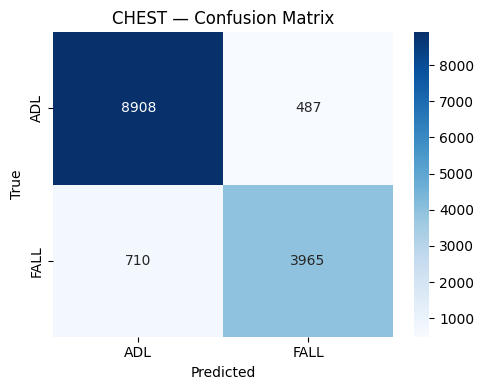

These features in provided data are not utilized by the predictor and will be ignored: ['dom_freq']
Computing feature importance via permutation shuffling for 22 features using 5000 rows with 5 shuffle sets...
	52.29s	= Expected runtime (10.46s per shuffle set)
	11.85s	= Actual runtime (Completed 5 of 5 shuffle sets)


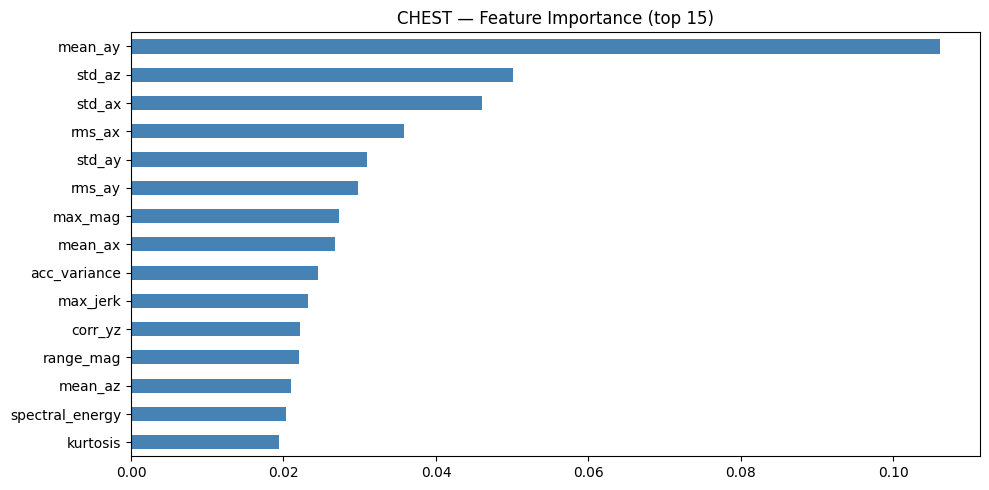

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ADL','FALL'], yticklabels=['ADL','FALL'])
plt.title(f'{PLACEMENT} — Confusion Matrix')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f'models/{PLACEMENT}_confusion.png', dpi=150)
plt.show()

try:
    fi = predictor.feature_importance(test_df)
    plt.figure(figsize=(10,5))
    fi['importance'].sort_values().tail(15).plot(kind='barh', color='steelblue')
    plt.title(f'{PLACEMENT} — Feature Importance (top 15)')
    plt.tight_layout()
    plt.savefig(f'models/{PLACEMENT}_importance.png', dpi=150)
    plt.show()
except Exception as e:
    print(f'Feature importance: {e}')

## 6. Save Results

In [9]:
results = {
    'placement': PLACEMENT, 'dataset': 'SisFall',
    'n_windows': len(feat_df), 'n_features': len(FEATURE_NAMES),
    'test_f1': float(f1_score(y_test, y_pred)),
    'precision': float(precision_score(y_test, y_pred)),
    'recall': float(recall_score(y_test, y_pred)),
    'auc': float(auc),
    'best_model': lb.iloc[0]['model'] if len(lb) > 0 else 'unknown',
}
pd.DataFrame([results]).to_csv(f'models/{PLACEMENT}_results.csv', index=False)
print(f'Saved models/{PLACEMENT}_results.csv')
for k,v in results.items(): print(f'  {k}: {v}')

Saved models/CHEST_results.csv
  placement: CHEST
  dataset: SisFall
  n_windows: 70346
  n_features: 23
  test_f1: 0.8688506628684124
  precision: 0.8906109613656783
  recall: 0.8481283422459893
  auc: 0.9679937843829777
  best_model: ExtraTreesEntr
